In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 563317212386736669
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7845593088
locality {
  bus_id: 1
}
incarnation: 7317070993819826259
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [2]:
"""
Build RBG Graph
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)


In [3]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb' 
imagenet_pretrained = True #should stay true for flow as well
print("wiener")
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                print("pretrained")
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
pretrained
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
Norm of logits: 87.108879

Top classes and probabilities
0.99999666 25.856651 playing cricket
1.335341e-06 12.330331 playing kickball
4.5531024e-07 11.254368 catching or throwing baseball
3.14341e-07 10.883867 shooting goal (soccer)
1.9243211e-07 10.393132 catching or throwing softball
1.3096448e-07 10.008315 throwing discus
1.0681766e-07 9.804511 javelin throw
9.446406e-08 9.681608 golf putting
7.8428855e-08 9.495581 jogging
7.801721e-08 9.490317 hitting baseball
6.608454e-08 9.324324 triple jump
3.487828e-08 8.685253 hurling (sport)
2.996551e-08 8.533437 skateboarding
2.1083729e-08 8.1818905 hurdling
2.007925e-08 8.133076 playing tennis
1.8453855e-08 8.048662 breakdancing
1.7050727e-08 7.9695816 hammer throw
1.7004478e-08 7.9668646 shot put
1.4611323e-08 7

In [4]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    start = time.time()
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    print("Blur time", time.time()-start)
    return X

In [5]:
def create_class_visualization(sess, target_y, logits, rgb_input, class_name, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    #still_seed = kwargs.pop('still_seed')
    
    # X = np.random.rand(num_frames, 224, 224, 3)
    X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=1)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            plt.imshow(X[0][0])
            
            if t == num_iterations-1:
                # save all frames
                print(X[0][0])
                directory = "experiments/{}".format(class_name)
                if not os.path.exists(directory):
                    os.makedirs(directory)
                file_name = directory + "/{}".format(class_name)+ "{}.png"
                print("file_name", file_name)
                filenames = []
                for i in range(0, num_frames):
                    plt.imshow(X[0][i])
                    filename = file_name.format(i)
                    filenames.append(filename)
                    plt.savefig(filename.format(i))
                    plt.show()
                #create gif
                images = []
                for filename in filenames:
                    images.append(imageio.imread(filename))
                    imageio.mimsave(directory + "/{}".format(class_name) + ".gif", images)
                    
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
deadlifting
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'num_iterations': 1000, 'learning_rate': 1.5, 'max_jitter': 32, 'blur_every': 3, 'num_frames': 25}
Blur time 0.157217025757
iteration: 0 2.20745301247


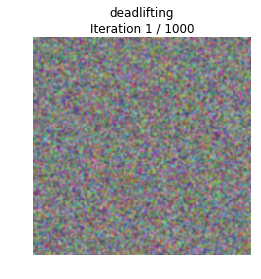

iteration: 1 3.97602200508
iteration: 2 5.60213398933
Blur time 0.122415065765
iteration: 3 7.39053893089
iteration: 4 8.95182681084
iteration: 5 10.6130509377
Blur time 0.117978096008
iteration: 6 12.3519999981
iteration: 7 13.9411139488
iteration: 8 15.5726029873
Blur time 0.103246927261
iteration: 9 17.3262438774
iteration: 10 18.8441150188
iteration: 11 20.4594600201
Blur time 0.119687795639
iteration: 12 22.1912298203
iteration: 13 23.7981069088
iteration: 14 25.4009099007
Blur time 0.100255012512
iteration: 15 27.0672600269
iteration: 16 28.6029758453
iteration: 17 30.2548048496
Blur time 0.0958330631256
iteration: 18 31.996958971
iteration: 19 33.5794138908
iteration: 20 35.1741528511
Blur time 0.15652012825
iteration: 21 36.9985969067
iteration: 22 38.5830588341
iteration: 23 40.1934649944
Blur time 0.0952441692352
iteration: 24 41.8959629536


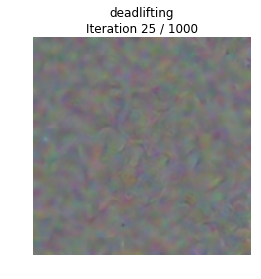

iteration: 25 43.5795538425
iteration: 26 45.1462388039
Blur time 0.101360082626
iteration: 27 46.8084189892
iteration: 28 48.3514418602
iteration: 29 49.9980318546
Blur time 0.111222028732
iteration: 30 51.7337219715
iteration: 31 53.3609108925
iteration: 32 54.9607539177
Blur time 0.107866048813
iteration: 33 56.6811909676
iteration: 34 58.2404048443
iteration: 35 59.8054208755
Blur time 0.140523910522
iteration: 36 61.5049510002
iteration: 37 63.1169810295
iteration: 38 64.6656219959
Blur time 0.125688076019
iteration: 39 66.393018961
iteration: 40 68.0513319969
iteration: 41 69.733809948
Blur time 0.115270853043
iteration: 42 71.3918228149
iteration: 43 73.004639864
iteration: 44 74.5556259155
Blur time 0.10311794281
iteration: 45 76.2444589138
iteration: 46 77.7851428986
iteration: 47 79.4329268932
Blur time 0.107553958893
iteration: 48 81.2162539959
iteration: 49 82.8752698898


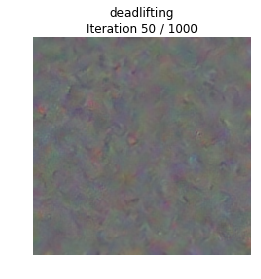

iteration: 50 84.6385769844
Blur time 0.102792024612
iteration: 51 86.3772199154
iteration: 52 87.9520628452
iteration: 53 89.5307528973
Blur time 0.157120943069
iteration: 54 91.2418029308
iteration: 55 92.8121759892
iteration: 56 94.3634397984
Blur time 0.102252960205
iteration: 57 96.0571198463
iteration: 58 97.6304168701
iteration: 59 99.2591519356
Blur time 0.138347148895
iteration: 60 101.005555868
iteration: 61 102.602583885
iteration: 62 104.15106988
Blur time 0.127818822861
iteration: 63 105.931983948
iteration: 64 107.505210876
iteration: 65 109.102706909
Blur time 0.14652299881
iteration: 66 110.860899925
iteration: 67 112.511991978
iteration: 68 114.182130814
Blur time 0.10537815094
iteration: 69 115.990494967
iteration: 70 117.527055025
iteration: 71 119.106355906
Blur time 0.147527933121
iteration: 72 120.857159853
iteration: 73 122.442077875
iteration: 74 124.013651848


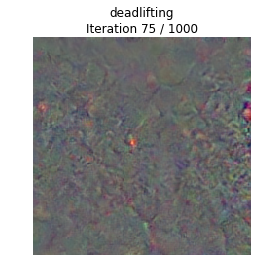

Blur time 0.162312984467
iteration: 75 125.902527809
iteration: 76 127.497560024
iteration: 77 129.096050024
Blur time 0.153213024139
iteration: 78 130.841114998
iteration: 79 132.471655846
iteration: 80 134.080323935
Blur time 0.108336925507
iteration: 81 135.949636936
iteration: 82 137.506490946
iteration: 83 139.107910872
Blur time 0.142629146576
iteration: 84 140.937273026
iteration: 85 142.582999945
iteration: 86 144.20250392
Blur time 0.120736122131
iteration: 87 146.010020018
iteration: 88 147.562456846
iteration: 89 149.205863953
Blur time 0.157205104828
iteration: 90 150.991523027
iteration: 91 152.619318962
iteration: 92 154.165716887
Blur time 0.132162809372
iteration: 93 155.885790825
iteration: 94 157.469918966
iteration: 95 159.160740852
Blur time 0.128843069077
iteration: 96 160.884902
iteration: 97 162.506415844
iteration: 98 164.160214901
Blur time 0.102134943008
iteration: 99 165.844470024


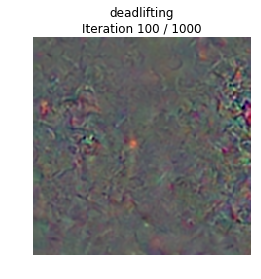

iteration: 100 167.505976915
iteration: 101 169.191102028
Blur time 0.150723934174
iteration: 102 171.025847912
iteration: 103 172.693240881
iteration: 104 174.346042871
Blur time 0.140096902847
iteration: 105 176.15316391
iteration: 106 177.767015934
iteration: 107 179.408815861
Blur time 0.11866402626
iteration: 108 181.107432842
iteration: 109 182.717985868
iteration: 110 184.30663681
Blur time 0.123429059982
iteration: 111 186.012283802
iteration: 112 187.602416992
iteration: 113 189.246256828
Blur time 0.0918569564819
iteration: 114 190.894235849
iteration: 115 192.480063915
iteration: 116 194.138504982
Blur time 0.154119968414
iteration: 117 195.867835999
iteration: 118 197.463742018
iteration: 119 199.040943861
Blur time 0.156803131104
iteration: 120 200.841241837
iteration: 121 202.513749838
iteration: 122 204.148459911
Blur time 0.15015411377
iteration: 123 205.969889879
iteration: 124 207.57230401


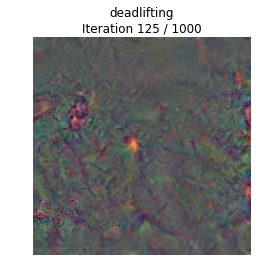

iteration: 125 209.25068593
Blur time 0.152486801147
iteration: 126 211.00551796
iteration: 127 212.676335812
iteration: 128 214.325181007
Blur time 0.110596895218
iteration: 129 216.101665974
iteration: 130 217.745864868
iteration: 131 219.419049978
Blur time 0.0962560176849
iteration: 132 221.130219936
iteration: 133 222.730471849
iteration: 134 224.388201952
Blur time 0.102269172668
iteration: 135 226.14961195
iteration: 136 227.703426838
iteration: 137 229.277961969
Blur time 0.105214834213
iteration: 138 230.976044893
iteration: 139 232.661870003
iteration: 140 234.368422985
Blur time 0.15754199028
iteration: 141 236.187567949
iteration: 142 237.845741987
iteration: 143 239.503348827
Blur time 0.154705047607
iteration: 144 241.222025871
iteration: 145 242.862098932
iteration: 146 244.51135397
Blur time 0.10706281662
iteration: 147 246.376632929
iteration: 148 247.941093922
iteration: 149 249.560383797


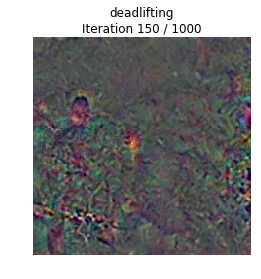

Blur time 0.121742963791
iteration: 150 251.480827808
iteration: 151 253.149560928
iteration: 152 254.77362299
Blur time 0.131316900253
iteration: 153 256.609382868
iteration: 154 258.228289843
iteration: 155 259.900982857
Blur time 0.107752084732
iteration: 156 261.664522886
iteration: 157 263.347929955
iteration: 158 265.026649952
Blur time 0.107474088669
iteration: 159 266.799328804
iteration: 160 268.341964006
iteration: 161 269.910936832
Blur time 0.131422042847
iteration: 162 271.647940874
iteration: 163 273.277199984
iteration: 164 274.929484844
Blur time 0.102126121521
iteration: 165 276.713824987
iteration: 166 278.298310995
iteration: 167 279.956760883
Blur time 0.14376282692
iteration: 168 281.69817996
iteration: 169 283.312742949
iteration: 170 284.93976903
Blur time 0.161858081818
iteration: 171 286.761449814
iteration: 172 288.380829811
iteration: 173 290.018904924
Blur time 0.149261951447
iteration: 174 291.874624014


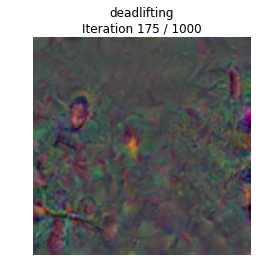

iteration: 175 293.71912384
iteration: 176 295.377472878
Blur time 0.139770030975
iteration: 177 297.221405029
iteration: 178 298.778438807
iteration: 179 300.354984999
Blur time 0.138916015625
iteration: 180 302.09947896
iteration: 181 303.732321024
iteration: 182 305.350586891
Blur time 0.147947072983
iteration: 183 307.097334862
iteration: 184 308.700093985
iteration: 185 310.36259985
Blur time 0.143282175064
iteration: 186 312.134804964
iteration: 187 313.774646997
iteration: 188 315.433661938
Blur time 0.13637804985
iteration: 189 317.218612909
iteration: 190 318.890736818
iteration: 191 320.530988932
Blur time 0.116341114044
iteration: 192 322.341102839
iteration: 193 323.97835803
iteration: 194 325.619162798
Blur time 0.158706903458
iteration: 195 327.483597994
iteration: 196 329.061551809
iteration: 197 330.633397818
Blur time 0.141268014908
iteration: 198 332.364139795
iteration: 199 333.992499828


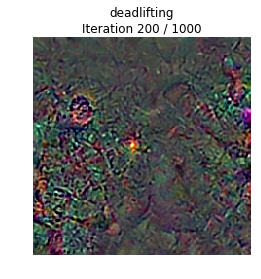

iteration: 200 335.768501997
Blur time 0.119783163071
iteration: 201 337.475463867
iteration: 202 339.16771698
iteration: 203 340.841014862
Blur time 0.146405935287
iteration: 204 342.547670841
iteration: 205 344.17326498
iteration: 206 345.806715012
Blur time 0.105283975601
iteration: 207 347.593477011
iteration: 208 349.141012907
iteration: 209 350.811415911
Blur time 0.15420794487
iteration: 210 352.6291008
iteration: 211 354.320614815
iteration: 212 355.996676922
Blur time 0.15922999382
iteration: 213 357.819103003
iteration: 214 359.519866943
iteration: 215 361.193733931
Blur time 0.159283876419
iteration: 216 362.932293892
iteration: 217 364.564345837
iteration: 218 366.164283991
Blur time 0.145565032959
iteration: 219 367.941499949
iteration: 220 369.517738819
iteration: 221 371.162801981
Blur time 0.149198055267
iteration: 222 372.973075867
iteration: 223 374.616171837
iteration: 224 376.246451855


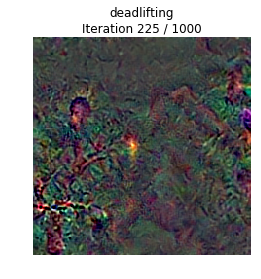

Blur time 0.155657052994
iteration: 225 378.120581865
iteration: 226 379.758961916
iteration: 227 381.546205997
Blur time 0.152724981308
iteration: 228 383.382572889
iteration: 229 385.043507814
iteration: 230 386.692433834
Blur time 0.150755882263
iteration: 231 388.50493598
iteration: 232 390.135589838
iteration: 233 391.788077831
Blur time 0.13377904892
iteration: 234 393.522095919
iteration: 235 395.187155008
iteration: 236 396.746584892
Blur time 0.106220960617
iteration: 237 398.513698816
iteration: 238 400.081598997
iteration: 239 401.726501942
Blur time 0.0987260341644
iteration: 240 403.457351923
iteration: 241 405.032482862
iteration: 242 406.632130861
Blur time 0.109385967255
iteration: 243 408.41178894
iteration: 244 410.006846905
iteration: 245 411.797557831
Blur time 0.151960134506
iteration: 246 413.698097944
iteration: 247 415.343274832
iteration: 248 417.007091999
Blur time 0.166445016861
iteration: 249 418.863837004


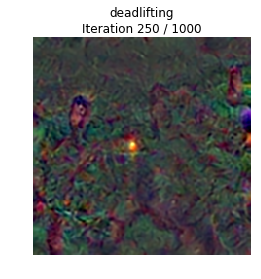

iteration: 250 420.607177019
iteration: 251 422.305687904
Blur time 0.154345035553
iteration: 252 424.128007889
iteration: 253 425.778013945
iteration: 254 427.422932863
Blur time 0.1081199646
iteration: 255 429.148454905
iteration: 256 430.714308023
iteration: 257 432.341503859
Blur time 0.145099878311
iteration: 258 434.184563875
iteration: 259 435.779974937
iteration: 260 437.362430811
Blur time 0.11409497261
iteration: 261 439.128983021
iteration: 262 440.721346855
iteration: 263 442.402951956
Blur time 0.146320819855
iteration: 264 444.224708796
iteration: 265 445.902650833
iteration: 266 447.510324955
Blur time 0.110342025757
iteration: 267 449.268091917
iteration: 268 450.81072402
iteration: 269 452.401540995
Blur time 0.147026062012
iteration: 270 454.127851009
iteration: 271 455.762424946
iteration: 272 457.345779896
Blur time 0.166230916977
iteration: 273 459.181736946
iteration: 274 460.80816102


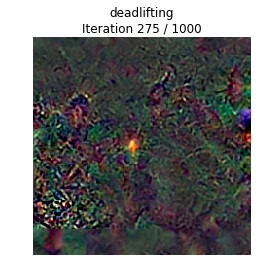

iteration: 275 462.580667973
Blur time 0.147975921631
iteration: 276 464.32333684
iteration: 277 465.936543941
iteration: 278 467.609397888
Blur time 0.15255188942
iteration: 279 469.531546831
iteration: 280 471.152724028
iteration: 281 472.813156843
Blur time 0.151709079742
iteration: 282 474.64268589
iteration: 283 476.283942938
iteration: 284 477.913791895
Blur time 0.151587963104
iteration: 285 479.782007933
iteration: 286 481.403043985
iteration: 287 483.066845894
Blur time 0.0942559242249
iteration: 288 484.747423887
iteration: 289 486.330515862
iteration: 290 487.91979003
Blur time 0.142220973969
iteration: 291 489.753642797
iteration: 292 491.373611927
iteration: 293 493.000734806
Blur time 0.129522800446
iteration: 294 494.8035779
iteration: 295 496.414803028
iteration: 296 498.004738808
Blur time 0.154201030731
iteration: 297 499.844407797
iteration: 298 501.476176023
iteration: 299 503.153060913


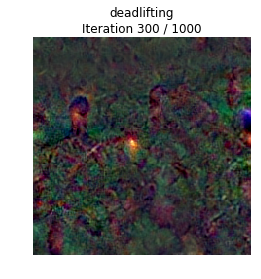

Blur time 0.151659965515
iteration: 300 505.036549807
iteration: 301 506.699352026
iteration: 302 508.360383987
Blur time 0.156795024872
iteration: 303 510.232635975
iteration: 304 511.829932928
iteration: 305 513.494597912
Blur time 0.122173070908
iteration: 306 515.18363595
iteration: 307 516.817756891
iteration: 308 518.417290926
Blur time 0.118428945541
iteration: 309 520.31920886
iteration: 310 521.92273283
iteration: 311 523.597533941
Blur time 0.138882160187
iteration: 312 525.308897018
iteration: 313 526.923200846
iteration: 314 528.4875319
Blur time 0.142960071564
iteration: 315 530.321476936
iteration: 316 531.931106806
iteration: 317 533.559706926
Blur time 0.0912539958954
iteration: 318 535.233472824
iteration: 319 536.860538006
iteration: 320 538.529084921
Blur time 0.12135386467
iteration: 321 540.338337898
iteration: 322 541.966763973
iteration: 323 543.555714846
Blur time 0.100323200226
iteration: 324 545.278889894


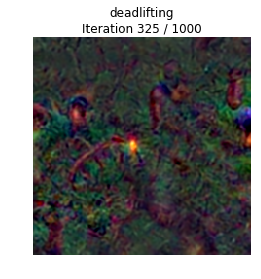

iteration: 325 547.022853851
iteration: 326 548.601992846
Blur time 0.104205131531
iteration: 327 550.282194853
iteration: 328 551.862846851
iteration: 329 553.501878977
Blur time 0.113052129745
iteration: 330 555.213850975
iteration: 331 556.932063818
iteration: 332 558.602576017
Blur time 0.112550973892
iteration: 333 560.361152887
iteration: 334 561.948935032
iteration: 335 563.554633856
Blur time 0.105493068695
iteration: 336 565.227802992
iteration: 337 566.828549862
iteration: 338 568.483639002
Blur time 0.150855064392
iteration: 339 570.285664797
iteration: 340 571.93424201
iteration: 341 573.581408024
Blur time 0.0927929878235
iteration: 342 575.285316944
iteration: 343 576.874709845
iteration: 344 578.527211905
Blur time 0.10258102417
iteration: 345 580.289075851
iteration: 346 581.843288898
iteration: 347 583.448698997
Blur time 0.0996370315552
iteration: 348 585.252144814
iteration: 349 586.855554819


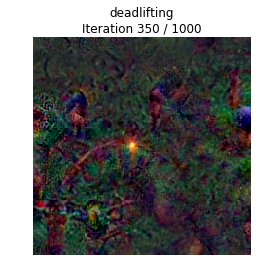

iteration: 350 588.541935921
Blur time 0.148222923279
iteration: 351 590.326962948
iteration: 352 591.937157869
iteration: 353 593.586368799
Blur time 0.109105110168
iteration: 354 595.245486975
iteration: 355 596.830956936
iteration: 356 598.486129999
Blur time 0.100404024124
iteration: 357 600.247859955
iteration: 358 601.881948948
iteration: 359 603.571841955
Blur time 0.142033815384
iteration: 360 605.363979816
iteration: 361 607.009418011
iteration: 362 608.656502962
Blur time 0.150267839432
iteration: 363 610.48465395
iteration: 364 612.087261915
iteration: 365 613.764775991
Blur time 0.141410112381
iteration: 366 615.566046
iteration: 367 617.189078808
iteration: 368 618.740509987
Blur time 0.116662979126
iteration: 369 620.439941883
iteration: 370 622.001880884
iteration: 371 623.735435963
Blur time 0.0926289558411
iteration: 372 625.491662025
iteration: 373 627.073637962
iteration: 374 628.666180849


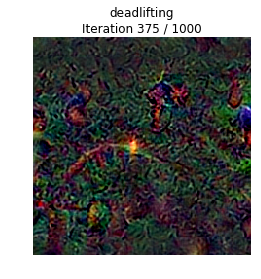

Blur time 0.148365974426
iteration: 375 630.597920895
iteration: 376 632.269264936
iteration: 377 633.974041939
Blur time 0.152232170105
iteration: 378 635.776166916
iteration: 379 637.371868849
iteration: 380 639.023690939
Blur time 0.143507957458
iteration: 381 640.822650909
iteration: 382 642.47308588
iteration: 383 644.096928835
Blur time 0.0915131568909
iteration: 384 645.863189936
iteration: 385 647.45396781
iteration: 386 649.142252922
Blur time 0.156145095825
iteration: 387 650.926925898
iteration: 388 652.539364815
iteration: 389 654.134804964
Blur time 0.144556999207
iteration: 390 655.845256805
iteration: 391 657.481815815
iteration: 392 659.103278875
Blur time 0.118618011475
iteration: 393 660.954519987
iteration: 394 662.601105928
iteration: 395 664.313561916
Blur time 0.142807006836
iteration: 396 666.087762833
iteration: 397 667.682787895
iteration: 398 669.243660927
Blur time 0.1622569561
iteration: 399 671.00430584


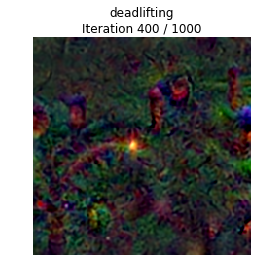

iteration: 400 672.717619896
iteration: 401 674.422544956
Blur time 0.146260976791
iteration: 402 676.153126955
iteration: 403 677.794751883
iteration: 404 679.447058916
Blur time 0.114980220795
iteration: 405 681.278162003
iteration: 406 682.904179811
iteration: 407 684.549875975
Blur time 0.137393951416
iteration: 408 686.348919868
iteration: 409 687.98238492
iteration: 410 689.627064943
Blur time 0.098443031311
iteration: 411 691.442222834
iteration: 412 693.069788933
iteration: 413 694.740815878
Blur time 0.100220918655
iteration: 414 696.483151913
iteration: 415 698.056298018
iteration: 416 699.644114017
Blur time 0.100776910782
iteration: 417 701.326026917
iteration: 418 702.904995918
iteration: 419 704.519560814
Blur time 0.0980339050293
iteration: 420 706.21050787
iteration: 421 707.78192687
iteration: 422 709.418018818
Blur time 0.141535997391
iteration: 423 711.153146982
iteration: 424 712.867013931


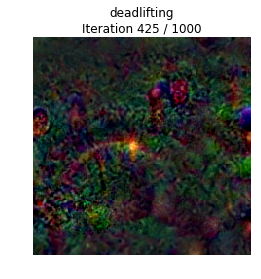

iteration: 425 714.666747808
Blur time 0.125887870789
iteration: 426 716.383976936
iteration: 427 717.998950005
iteration: 428 719.619495869
Blur time 0.102784872055
iteration: 429 721.429196835
iteration: 430 723.066286802
iteration: 431 724.757133961
Blur time 0.114668130875
iteration: 432 726.546334982
iteration: 433 728.140429974
iteration: 434 729.731889009
Blur time 0.138016223907
iteration: 435 731.535509825
iteration: 436 733.169030905
iteration: 437 734.856416941
Blur time 0.146435976028
iteration: 438 736.690886974
iteration: 439 738.319471836
iteration: 440 739.923501015
Blur time 0.147892951965
iteration: 441 741.722151995
iteration: 442 743.330507994
iteration: 443 745.020238876
Blur time 0.0983870029449
iteration: 444 746.715722799
iteration: 445 748.310437918
iteration: 446 749.957278967
Blur time 0.113841056824
iteration: 447 751.690804958
iteration: 448 753.346228838
iteration: 449 755.004836798


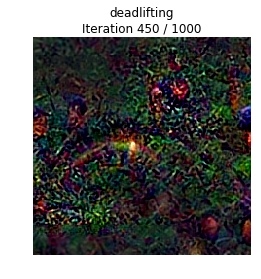

Blur time 0.113991975784
iteration: 450 756.879524946
iteration: 451 758.498773813
iteration: 452 760.180845976
Blur time 0.102979183197
iteration: 453 761.981644869
iteration: 454 763.533030987
iteration: 455 765.237123966
Blur time 0.142014980316
iteration: 456 767.090790033
iteration: 457 768.736550808
iteration: 458 770.396471024
Blur time 0.103025197983
iteration: 459 772.171150923
iteration: 460 773.732594967
iteration: 461 775.335042
Blur time 0.0967800617218
iteration: 462 777.04615283
iteration: 463 778.641819
iteration: 464 780.265547991
Blur time 0.10978603363
iteration: 465 781.999241829
iteration: 466 783.646135807
iteration: 467 785.299302816
Blur time 0.0958750247955
iteration: 468 787.029173851
iteration: 469 788.701743841
iteration: 470 790.382849932
Blur time 0.151343107224
iteration: 471 792.169041872
iteration: 472 793.787148952
iteration: 473 795.372228861
Blur time 0.0918600559235
iteration: 474 797.105655909


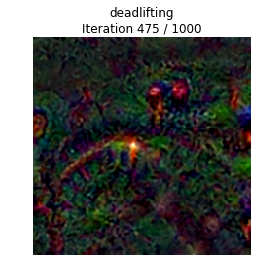

iteration: 475 798.803591013
iteration: 476 800.458019018
Blur time 0.102689027786
iteration: 477 802.236658812
iteration: 478 803.802981853
iteration: 479 805.384806871
Blur time 0.12095117569
iteration: 480 807.143134832
iteration: 481 808.76819396
iteration: 482 810.379782915
Blur time 0.11300611496
iteration: 483 812.168435812
iteration: 484 813.811422825
iteration: 485 815.571455956
Blur time 0.093022108078
iteration: 486 817.314707994
iteration: 487 818.979030848
iteration: 488 820.570369959
Blur time 0.102913856506
iteration: 489 822.293283939
iteration: 490 823.857330799
iteration: 491 825.579773903
Blur time 0.100703954697
iteration: 492 827.436424017
iteration: 493 829.155300856
iteration: 494 830.779086828
Blur time 0.11353802681
iteration: 495 832.502017975
iteration: 496 834.089387894
iteration: 497 835.685971975
Blur time 0.156049013138
iteration: 498 837.456954002
iteration: 499 839.106459856


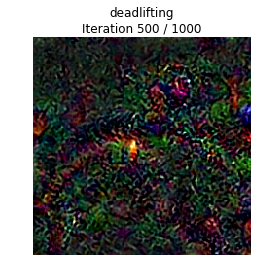

iteration: 500 840.842695951
Blur time 0.146253108978
iteration: 501 842.624202967
iteration: 502 844.272967815
iteration: 503 845.9424119
Blur time 0.145076036453
iteration: 504 847.847527981
iteration: 505 849.523718834
iteration: 506 851.149508953
Blur time 0.101119041443
iteration: 507 852.885551929
iteration: 508 854.456534863
iteration: 509 856.070104837
Blur time 0.155116081238
iteration: 510 857.866554976
iteration: 511 859.496666908
iteration: 512 861.122989893
Blur time 0.142282962799
iteration: 513 862.905689001
iteration: 514 864.529026985
iteration: 515 866.219599009
Blur time 0.0964071750641
iteration: 516 867.995775938
iteration: 517 869.602944851
iteration: 518 871.258013964
Blur time 0.152960062027
iteration: 519 873.033773899
iteration: 520 874.691268921
iteration: 521 876.413913012
Blur time 0.101336956024
iteration: 522 878.223523855
iteration: 523 879.858448029
iteration: 524 881.464095831


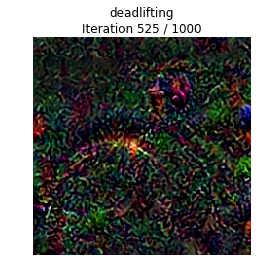

Blur time 0.148395061493
iteration: 525 883.408030033
iteration: 526 884.99909997
iteration: 527 886.587445974
Blur time 0.109533071518
iteration: 528 888.355386972
iteration: 529 889.975566864
iteration: 530 891.652248859
Blur time 0.141202926636
iteration: 531 893.448686838
iteration: 532 895.074764013
iteration: 533 896.724201918
Blur time 0.148887872696
iteration: 534 898.575874805
iteration: 535 900.233537912
iteration: 536 901.920282841
Blur time 0.152575016022
iteration: 537 903.669144869
iteration: 538 905.272096872
iteration: 539 906.904280901
Blur time 0.119489908218
iteration: 540 908.699041843
iteration: 541 910.329757929
iteration: 542 911.968590975
Blur time 0.103882074356
iteration: 543 913.780921936
iteration: 544 915.370584965
iteration: 545 916.973570824
Blur time 0.151275873184
iteration: 546 918.782022953
iteration: 547 920.423691988
iteration: 548 922.123706818
Blur time 0.0963199138641
iteration: 549 923.861362934


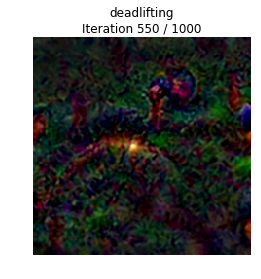

iteration: 550 925.527201891
iteration: 551 927.100312948
Blur time 0.0963687896729
iteration: 552 928.793853998
iteration: 553 930.361348867
iteration: 554 931.93425703
Blur time 0.152444839478
iteration: 555 933.755357981
iteration: 556 935.415551901
iteration: 557 937.081781864
Blur time 0.0970911979675
iteration: 558 938.816290855
iteration: 559 940.50660181
iteration: 560 942.18401885
Blur time 0.0951068401337
iteration: 561 943.952190876
iteration: 562 945.515910864
iteration: 563 947.116596937
Blur time 0.149955034256
iteration: 564 948.872990847
iteration: 565 950.520633936
iteration: 566 952.107383966
Blur time 0.0963401794434
iteration: 567 953.882336855
iteration: 568 955.457103014
iteration: 569 957.056569815
Blur time 0.127331018448
iteration: 570 958.848191023
iteration: 571 960.481595993
iteration: 572 962.163997889
Blur time 0.143335103989
iteration: 573 963.914628029
iteration: 574 965.527472019


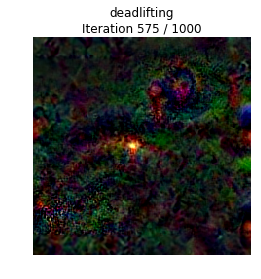

iteration: 575 967.286406994
Blur time 0.117243051529
iteration: 576 969.052310944
iteration: 577 970.73465395
iteration: 578 972.43959403
Blur time 0.153172969818
iteration: 579 974.300242901
iteration: 580 975.898756027
iteration: 581 977.50001502
Blur time 0.0938489437103
iteration: 582 979.203637838
iteration: 583 980.788197994
iteration: 584 982.437729836
Blur time 0.140480995178
iteration: 585 984.310580015
iteration: 586 985.923713923
iteration: 587 987.554433823
Blur time 0.144050121307
iteration: 588 989.35957098
iteration: 589 991.078360796
iteration: 590 992.719679832
Blur time 0.124376058578
iteration: 591 994.519567013
iteration: 592 996.129809856
iteration: 593 997.699433804
Blur time 0.0944900512695
iteration: 594 999.368721008
iteration: 595 1001.01065302
iteration: 596 1002.69854593
Blur time 0.0986280441284
iteration: 597 1004.47726583
iteration: 598 1006.11423588
iteration: 599 1007.78207183


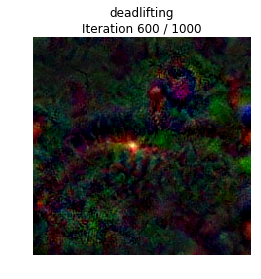

Blur time 0.140784025192
iteration: 600 1009.65306401
iteration: 601 1011.28889799
iteration: 602 1012.91359282
Blur time 0.0962390899658
iteration: 603 1014.65854502
iteration: 604 1016.21927881
iteration: 605 1017.80025101
Blur time 0.0919160842896
iteration: 606 1019.45163298
iteration: 607 1021.0663259
iteration: 608 1022.69569993
Blur time 0.0946049690247
iteration: 609 1024.37590289
iteration: 610 1025.9705658
iteration: 611 1027.64120102
Blur time 0.147954940796
iteration: 612 1029.47930098
iteration: 613 1031.12374902
iteration: 614 1032.80895281
Blur time 0.153595924377
iteration: 615 1034.61743593
iteration: 616 1036.27069783
iteration: 617 1037.88193393
Blur time 0.132361888885
iteration: 618 1039.59465003
iteration: 619 1041.27158594
iteration: 620 1042.97130203
Blur time 0.139258861542
iteration: 621 1044.75347686
iteration: 622 1046.38285685
iteration: 623 1048.07759881
Blur time 0.140985012054
iteration: 624 1049.91669798


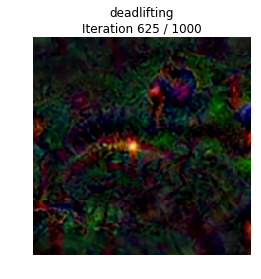

iteration: 625 1051.66074085
iteration: 626 1053.28474903
Blur time 0.118610143661
iteration: 627 1055.10557294
iteration: 628 1056.72662091
iteration: 629 1058.36543489
Blur time 0.122626781464
iteration: 630 1060.09094596
iteration: 631 1061.76828194
iteration: 632 1063.4087038
Blur time 0.145067930222
iteration: 633 1065.2235558
iteration: 634 1066.86832595
iteration: 635 1068.56129193
Blur time 0.158442974091
iteration: 636 1070.33957887
iteration: 637 1071.96971297
iteration: 638 1073.57463098
Blur time 0.144967794418
iteration: 639 1075.42703891
iteration: 640 1077.048944
iteration: 641 1078.6802299
Blur time 0.141539096832
iteration: 642 1080.51487899
iteration: 643 1082.14804482
iteration: 644 1083.73450899
Blur time 0.107182979584
iteration: 645 1085.43315196
iteration: 646 1087.06378794
iteration: 647 1088.81837988
Blur time 0.0990619659424
iteration: 648 1090.51422191
iteration: 649 1092.18768787


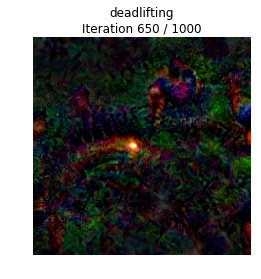

iteration: 650 1093.95081091
Blur time 0.144668102264
iteration: 651 1095.78454781
iteration: 652 1097.45170283
iteration: 653 1099.15787888
Blur time 0.149271011353
iteration: 654 1100.98483396
iteration: 655 1102.60044384
iteration: 656 1104.20994997
Blur time 0.104900836945
iteration: 657 1106.00421691
iteration: 658 1107.60232401
iteration: 659 1109.189533
Blur time 0.0917949676514
iteration: 660 1110.89113498
iteration: 661 1112.49365091
iteration: 662 1114.14028502
Blur time 0.104694128036
iteration: 663 1115.85644984
iteration: 664 1117.46579194
iteration: 665 1119.09761286
Blur time 0.100539207458
iteration: 666 1120.86810684
iteration: 667 1122.52178001
iteration: 668 1124.16711283
Blur time 0.0953660011292
iteration: 669 1125.96341896
iteration: 670 1127.60103297
iteration: 671 1129.24453688
Blur time 0.146282911301
iteration: 672 1131.00862694
iteration: 673 1132.66883087
iteration: 674 1134.24601889


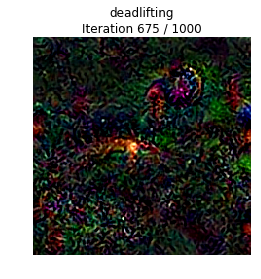

Blur time 0.11520409584
iteration: 675 1136.12056303
iteration: 676 1137.74013186
iteration: 677 1139.43251801
Blur time 0.137511968613
iteration: 678 1141.23909402
iteration: 679 1142.8702929
iteration: 680 1144.52433181
Blur time 0.147101163864
iteration: 681 1146.3809588
iteration: 682 1148.02084684
iteration: 683 1149.67610192
Blur time 0.134730100632
iteration: 684 1151.5528059
iteration: 685 1153.20286894
iteration: 686 1154.88555193
Blur time 0.0952851772308
iteration: 687 1156.66444087
iteration: 688 1158.2874589
iteration: 689 1159.88641787
Blur time 0.15589094162
iteration: 690 1161.6979208
iteration: 691 1163.338516
iteration: 692 1164.93182492
Blur time 0.168561935425
iteration: 693 1166.76212096
iteration: 694 1168.37122393
iteration: 695 1169.97063899
Blur time 0.138441085815
iteration: 696 1171.77311993
iteration: 697 1173.40647984
iteration: 698 1174.99424696
Blur time 0.121725082397
iteration: 699 1176.7563529


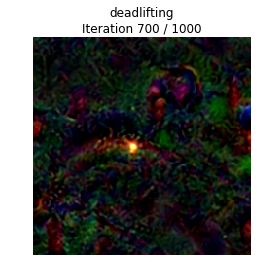

iteration: 700 1178.57217598
iteration: 701 1180.2648499
Blur time 0.146685838699
iteration: 702 1182.09522486
iteration: 703 1183.76430392
iteration: 704 1185.44231796
Blur time 0.121283054352
iteration: 705 1187.27887702
iteration: 706 1188.93817401
iteration: 707 1190.60624886
Blur time 0.148998022079
iteration: 708 1192.45651484
iteration: 709 1194.09863901
iteration: 710 1195.769943
Blur time 0.147488832474
iteration: 711 1197.59017897
iteration: 712 1199.20804286
iteration: 713 1200.86393285
Blur time 0.148746967316
iteration: 714 1202.67363787
iteration: 715 1204.32826281
iteration: 716 1205.95597291
Blur time 0.140826225281
iteration: 717 1207.69074702
iteration: 718 1209.30630493
iteration: 719 1210.97924399
Blur time 0.0954689979553
iteration: 720 1212.79168892
iteration: 721 1214.41103697
iteration: 722 1216.28190994
Blur time 0.148079872131
iteration: 723 1218.25132895
iteration: 724 1220.06362987


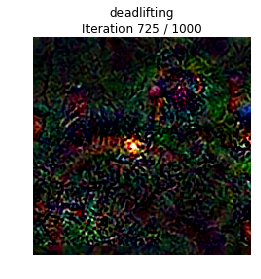

iteration: 725 1221.853719
Blur time 0.14030122757
iteration: 726 1223.64340687
iteration: 727 1225.37771583
iteration: 728 1227.031739
Blur time 0.098953962326
iteration: 729 1228.736027
iteration: 730 1230.34507203
iteration: 731 1232.00495195
Blur time 0.120887041092
iteration: 732 1233.74936891
iteration: 733 1235.39969182
iteration: 734 1237.01997399
Blur time 0.14897108078
iteration: 735 1238.87272382
iteration: 736 1240.50564098
iteration: 737 1242.18524384
Blur time 0.142257928848
iteration: 738 1244.03191996
iteration: 739 1245.69235396
iteration: 740 1247.39939189
Blur time 0.101093053818
iteration: 741 1249.22261691
iteration: 742 1250.87171483
iteration: 743 1252.52006197
Blur time 0.124494075775
iteration: 744 1254.26396585
iteration: 745 1255.86277699
iteration: 746 1257.52406383
Blur time 0.12090587616
iteration: 747 1259.22648787
iteration: 748 1260.84172797
iteration: 749 1262.44949985


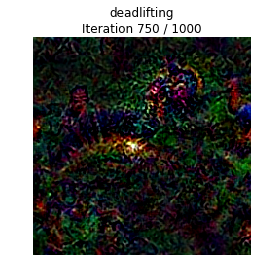

Blur time 0.0938980579376
iteration: 750 1264.29507303
iteration: 751 1265.8808248
iteration: 752 1267.47584081
Blur time 0.0967140197754
iteration: 753 1269.24077582
iteration: 754 1270.83129287
iteration: 755 1272.53978682
Blur time 0.149756908417
iteration: 756 1274.36907482
iteration: 757 1276.02740002
iteration: 758 1277.67499995
Blur time 0.132677078247
iteration: 759 1279.49423003
iteration: 760 1281.13323593
iteration: 761 1282.8371129
Blur time 0.151756048203
iteration: 762 1284.60605288
iteration: 763 1286.24941897
iteration: 764 1287.84470701
Blur time 0.133574962616
iteration: 765 1289.57278991
iteration: 766 1291.21937895
iteration: 767 1292.89560795
Blur time 0.121701955795
iteration: 768 1294.59931087
iteration: 769 1296.23986292
iteration: 770 1297.83186102
Blur time 0.0960688591003
iteration: 771 1299.51940799
iteration: 772 1301.12962699
iteration: 773 1302.73116302
Blur time 0.141387939453
iteration: 774 1304.53591084


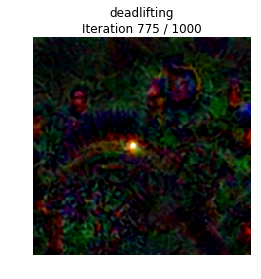

iteration: 775 1306.413234
iteration: 776 1308.10295796
Blur time 0.150587081909
iteration: 777 1309.97474289
iteration: 778 1311.6443398
iteration: 779 1313.37671781
Blur time 0.157852172852
iteration: 780 1315.28109097
iteration: 781 1316.88132
iteration: 782 1318.49520302
Blur time 0.143671989441
iteration: 783 1320.33468795
iteration: 784 1321.97026587
iteration: 785 1323.65261698
Blur time 0.148352146149
iteration: 786 1325.51220989
iteration: 787 1327.27439785
iteration: 788 1328.95634103
Blur time 0.156157970428
iteration: 789 1330.74681902
iteration: 790 1332.3657279
iteration: 791 1333.95228791
Blur time 0.137234926224
iteration: 792 1335.80151796
iteration: 793 1337.47183299
iteration: 794 1339.17033601
Blur time 0.145650863647
iteration: 795 1340.96417499
iteration: 796 1342.63117099
iteration: 797 1344.32219982
Blur time 0.142092943192
iteration: 798 1346.13508582
iteration: 799 1347.77547693


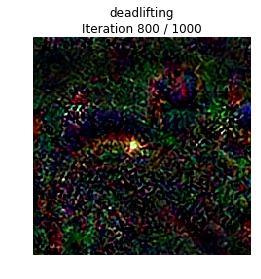

iteration: 800 1349.49789
Blur time 0.151104927063
iteration: 801 1351.36622596
iteration: 802 1353.002949
iteration: 803 1354.65978098
Blur time 0.143621921539
iteration: 804 1356.5228498
iteration: 805 1358.18904686
iteration: 806 1359.86480689
Blur time 0.0965201854706
iteration: 807 1361.64850998
iteration: 808 1363.25134087
iteration: 809 1364.85324883
Blur time 0.15530705452
iteration: 810 1366.65840697
iteration: 811 1368.29232097
iteration: 812 1369.87760282
Blur time 0.115827798843
iteration: 813 1371.57332182
iteration: 814 1373.2106719
iteration: 815 1374.83643103
Blur time 0.144890069962
iteration: 816 1376.62420082
iteration: 817 1378.29393387
iteration: 818 1379.91911387
Blur time 0.145649909973
iteration: 819 1381.741359
iteration: 820 1383.35617089
iteration: 821 1385.00948501
Blur time 0.112108945847
iteration: 822 1386.77621198
iteration: 823 1388.39740181
iteration: 824 1390.022439


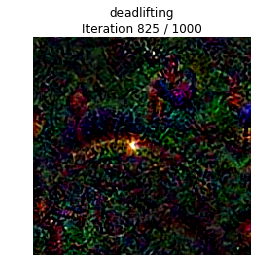

Blur time 0.105877876282
iteration: 825 1391.9102428
iteration: 826 1393.52248287
iteration: 827 1395.19380999
Blur time 0.0967299938202
iteration: 828 1396.89695883
iteration: 829 1398.5097518
iteration: 830 1400.25539088
Blur time 0.151860952377
iteration: 831 1402.1278429
iteration: 832 1403.79460502
iteration: 833 1405.52944803
Blur time 0.11532497406
iteration: 834 1407.3663578
iteration: 835 1409.03929996
iteration: 836 1410.7546289
Blur time 0.126393079758
iteration: 837 1412.56545591
iteration: 838 1414.24224091
iteration: 839 1415.84193182
Blur time 0.146472215652
iteration: 840 1417.6187849
iteration: 841 1419.28596282
iteration: 842 1420.93944097
Blur time 0.133129119873
iteration: 843 1422.69769692
iteration: 844 1424.38206291
iteration: 845 1425.98413491
Blur time 0.148848056793
iteration: 846 1427.77993989
iteration: 847 1429.39679098
iteration: 848 1430.98711085
Blur time 0.0963950157166
iteration: 849 1432.75554895


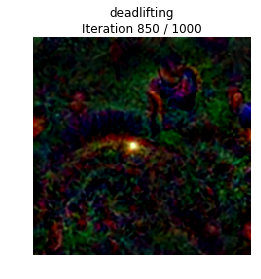

iteration: 850 1434.50922489
iteration: 851 1436.29872394
Blur time 0.147686004639
iteration: 852 1438.13777399
iteration: 853 1439.8140378
iteration: 854 1441.51547289
Blur time 0.109925985336
iteration: 855 1443.21140385
iteration: 856 1444.81847095
iteration: 857 1446.41402197
Blur time 0.153451919556
iteration: 858 1448.27613997
iteration: 859 1449.94441295
iteration: 860 1451.64328694
Blur time 0.144093036652
iteration: 861 1453.50107598
iteration: 862 1455.13968992
iteration: 863 1456.8407588
Blur time 0.0902290344238
iteration: 864 1458.558038
iteration: 865 1460.14323401
iteration: 866 1461.81128502
Blur time 0.0961148738861
iteration: 867 1463.49842095
iteration: 868 1465.07063389
iteration: 869 1466.68819785
Blur time 0.127466917038
iteration: 870 1468.51961088
iteration: 871 1470.19292784
iteration: 872 1471.9005599
Blur time 0.145356893539
iteration: 873 1473.7908988
iteration: 874 1475.44133687


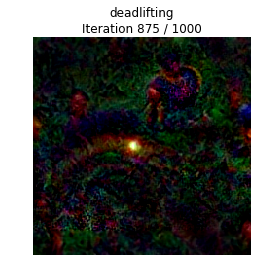

iteration: 875 1477.36647391
Blur time 0.131432056427
iteration: 876 1479.17468691
iteration: 877 1480.81473184
iteration: 878 1482.41581893
Blur time 0.116282939911
iteration: 879 1484.19010496
iteration: 880 1485.79731488
iteration: 881 1487.390064
Blur time 0.134907007217
iteration: 882 1489.11570191
iteration: 883 1490.76894188
iteration: 884 1492.45317388
Blur time 0.144743919373
iteration: 885 1494.28305483
iteration: 886 1495.94174981
iteration: 887 1497.6308279
Blur time 0.121606826782
iteration: 888 1499.4409318
iteration: 889 1501.20812297
iteration: 890 1502.87841702
Blur time 0.122668981552
iteration: 891 1504.68640995
iteration: 892 1506.3021009
iteration: 893 1508.01209497
Blur time 0.145062923431
iteration: 894 1509.91808295
iteration: 895 1511.55848503
iteration: 896 1513.20011282
Blur time 0.147145032883
iteration: 897 1515.04218793
iteration: 898 1516.68568492
iteration: 899 1518.36416793


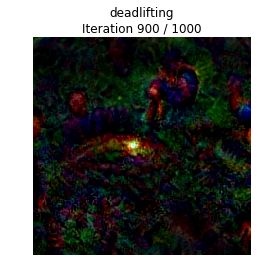

Blur time 0.148792028427
iteration: 900 1520.30114484
iteration: 901 1521.95496082
iteration: 902 1523.56067681
Blur time 0.115509986877
iteration: 903 1525.43776703
iteration: 904 1527.0732038
iteration: 905 1528.84135103
Blur time 0.148947954178
iteration: 906 1530.76374102
iteration: 907 1532.42714787
iteration: 908 1534.12213302
Blur time 0.140315055847
iteration: 909 1535.960495
iteration: 910 1537.56229281
iteration: 911 1539.22243094
Blur time 0.0947470664978
iteration: 912 1540.90338182
iteration: 913 1542.4855659
iteration: 914 1544.07799387
Blur time 0.0914151668549
iteration: 915 1545.83738184
iteration: 916 1547.41663003
iteration: 917 1549.12864399
Blur time 0.139138936996
iteration: 918 1550.937047
iteration: 919 1552.66710591
iteration: 920 1554.36806893
Blur time 0.133595943451
iteration: 921 1556.17802501
iteration: 922 1557.80903792
iteration: 923 1559.45264482
Blur time 0.147190093994
iteration: 924 1561.26043701


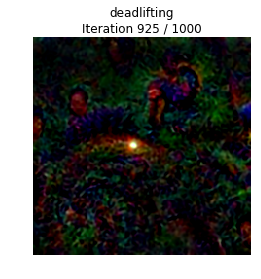

iteration: 925 1563.03958297
iteration: 926 1564.68672085
Blur time 0.132190942764
iteration: 927 1566.50650001
iteration: 928 1568.17353392
iteration: 929 1569.8747859
Blur time 0.0937929153442
iteration: 930 1571.63629985
iteration: 931 1573.22774386
iteration: 932 1574.9115119
Blur time 0.147644042969
iteration: 933 1576.73845196
iteration: 934 1578.39254284
iteration: 935 1580.0303688
Blur time 0.109029054642
iteration: 936 1581.82053399
iteration: 937 1583.50527191
iteration: 938 1585.17623496
Blur time 0.142746210098
iteration: 939 1586.91957593
iteration: 940 1588.5787549
iteration: 941 1590.28833199
Blur time 0.155724048615
iteration: 942 1592.15629792
iteration: 943 1593.85599494
iteration: 944 1595.57748389
Blur time 0.111993789673
iteration: 945 1597.40367603
iteration: 946 1599.25461888
iteration: 947 1600.92154884
Blur time 0.117149114609
iteration: 948 1602.75025392
iteration: 949 1604.47870493


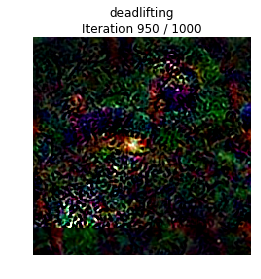

iteration: 950 1606.22283196
Blur time 0.150384902954
iteration: 951 1608.05781102
iteration: 952 1609.70465398
iteration: 953 1611.32798791
Blur time 0.120805978775
iteration: 954 1613.06610394
iteration: 955 1614.72830582
iteration: 956 1616.39428186
Blur time 0.103413820267
iteration: 957 1618.08287787
iteration: 958 1619.69605494
iteration: 959 1621.303128
Blur time 0.0961558818817
iteration: 960 1623.03703499
iteration: 961 1624.62757802
iteration: 962 1626.28056693
Blur time 0.124176025391
iteration: 963 1628.05561781
iteration: 964 1629.72066784
iteration: 965 1631.35558295
Blur time 0.116789102554
iteration: 966 1633.06531191
iteration: 967 1634.69158387
iteration: 968 1636.3970058
Blur time 0.0948700904846
iteration: 969 1638.1959188
iteration: 970 1639.80344081
iteration: 971 1641.50767899
Blur time 0.103299856186
iteration: 972 1643.20260191
iteration: 973 1644.89692593
iteration: 974 1646.55993795


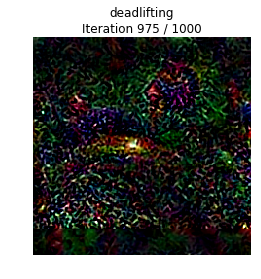

Blur time 0.111701011658
iteration: 975 1648.36319089
iteration: 976 1649.99330497
iteration: 977 1651.65861893
Blur time 0.14276099205
iteration: 978 1653.49558282
iteration: 979 1655.14668083
iteration: 980 1656.8503468
Blur time 0.092845916748
iteration: 981 1658.66297698
iteration: 982 1660.33843398
iteration: 983 1662.03356385
Blur time 0.0939657688141
iteration: 984 1663.81872892
iteration: 985 1665.407552
iteration: 986 1666.98993993
Blur time 0.151047945023
iteration: 987 1668.72868681
iteration: 988 1670.3685329
iteration: 989 1672.12339401
Blur time 0.0918459892273
iteration: 990 1673.91154289
iteration: 991 1675.51370287
iteration: 992 1677.28755498
Blur time 0.0906100273132
iteration: 993 1679.00107288
iteration: 994 1680.58634996
iteration: 995 1682.20146799
Blur time 0.0922031402588
iteration: 996 1683.89318395
iteration: 997 1685.49584103
iteration: 998 1687.1852138
Blur time 0.109148979187
iteration: 999 1688.91881895
file_name experiments/deadlifting/deadlifting{}.png


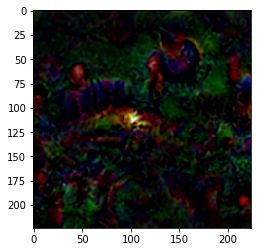

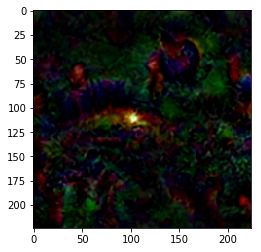

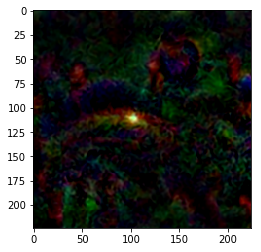

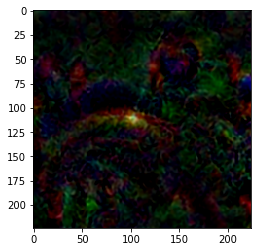

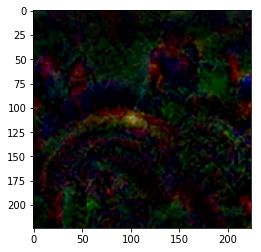

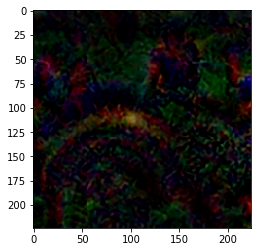

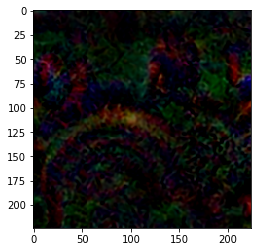

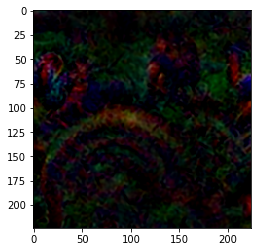

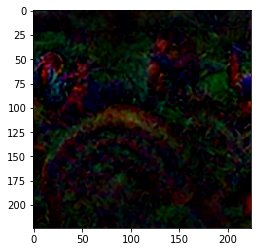

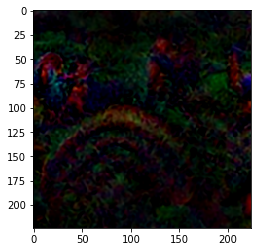

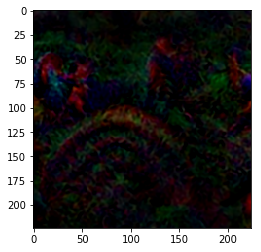

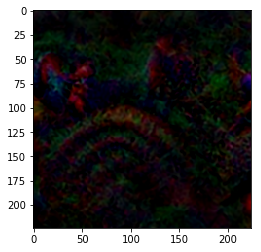

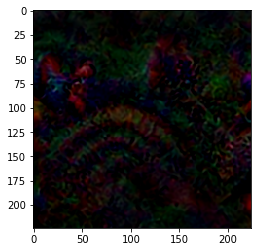

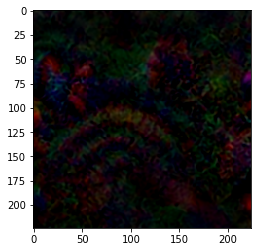

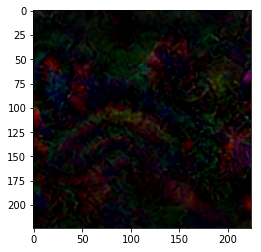

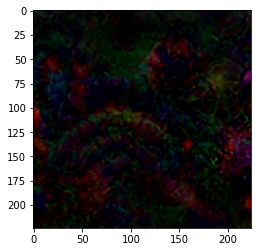

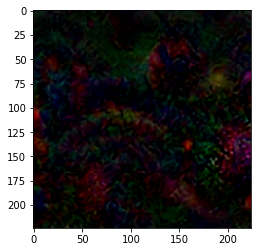

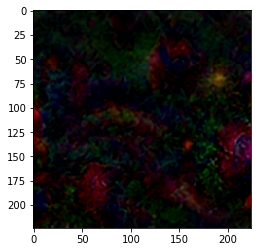

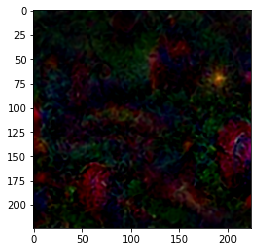

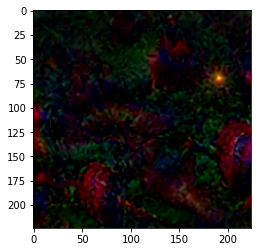

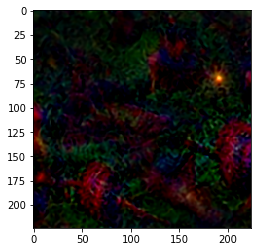

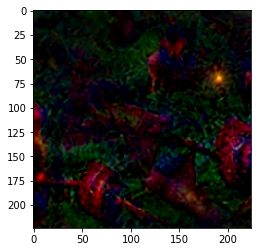

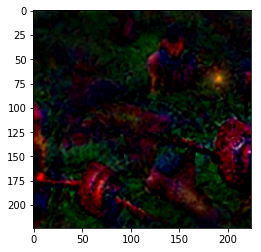

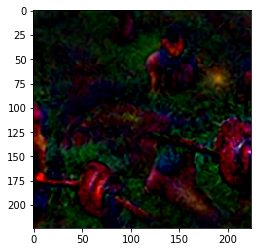

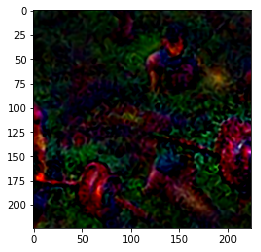

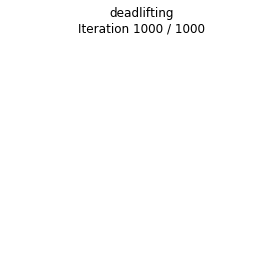

In [14]:
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
target = 88
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, target, model_logits, rgb_input, action_name, num_frames=25, num_iterations=1000, learning_rate=1.5, blur_every=3, max_jitter=32)

In [ ]:
if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)